(-0.5, 3839.5, 1759.5, -0.5)

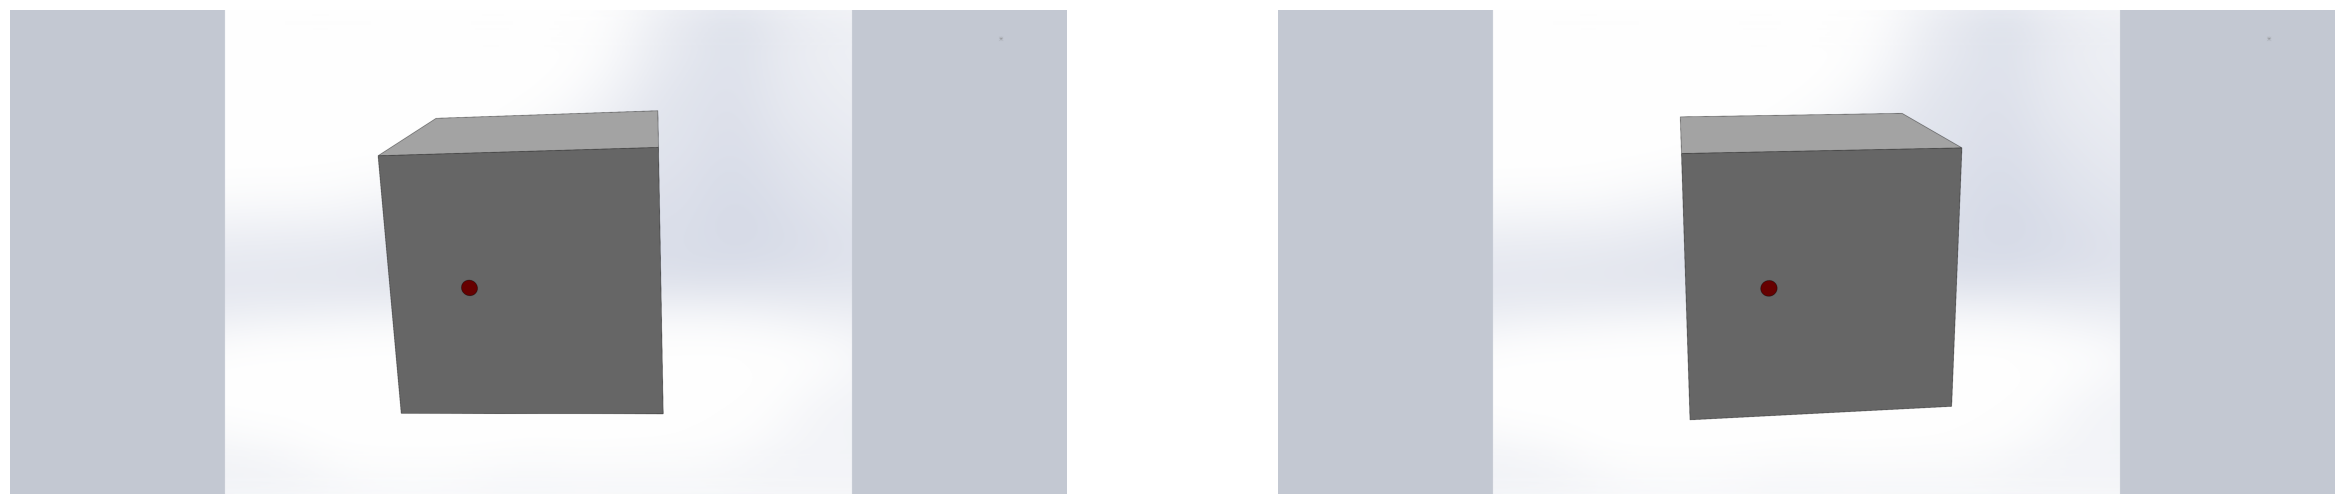

In [13]:
from PIL import Image

import cv2, glob, os
import matplotlib.pyplot as plt
from plotly.graph_objs.layout.scene import Aspectratio

base = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Kamera_Simulationen\Solidworks"
patterns = [os.path.join(base, "**", "*.jpg"),
            os.path.join(base, "**", "*.jpeg"),
            os.path.join(base, "**", "*.png")]
images = []
for pat in patterns:
    images.extend(glob.glob(pat, recursive=True))

img1 = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(images[1]), cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')


w:  3840 , h:  1760


(-0.5, 2276.5, 1759.5, -0.5)

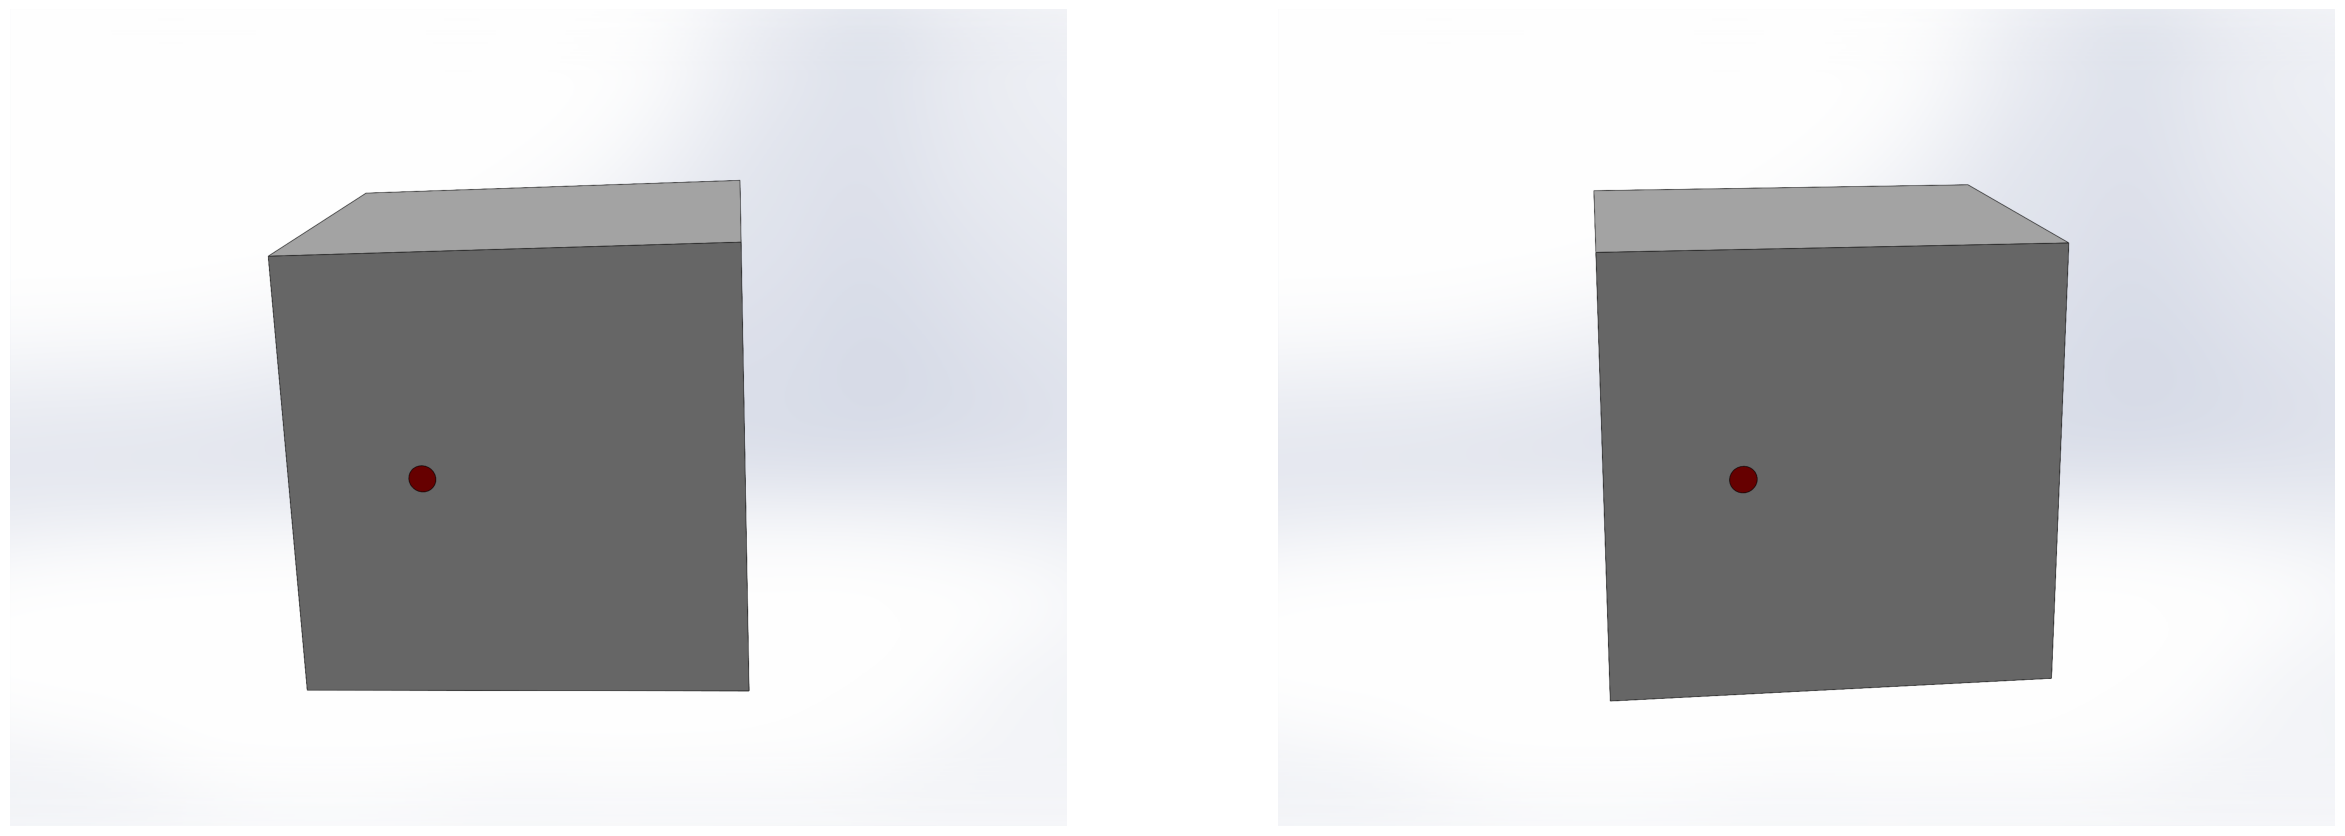

In [14]:
import numpy as np
import matplotlib.pyplot as plt
Aspectratio = (8.5, 11)
dk = 50         #mm
ak = 13.77      #°
vc1 = np.array([25, 53.59, 200])
vc2 = np.array([-25, 53.59, 200])
h, w, _ = img1.shape
print("w: ", w, ", h: ", h)
def croptoaspect(img, ar):
    w, h, _ = img.shape
    target_ratio = ar[0] / ar[1]  # width / height
    # Center-crop to target aspect ratio
    if (w / h) > target_ratio:
        # too wide -> crop width
        new_w = int(h * target_ratio)
        x0 = (w - new_w) // 2
        y0 = 0
        x1 = x0 + new_w
        y1 = h
    else:
        # too tall -> crop height
        new_h = int(w / target_ratio)
        x0 = 0
        y0 = (h - new_h) // 2
        x1 = w
        y1 = y0 + new_h

    return img[x0:x1, y0:y1]
img1, img2 = croptoaspect(img1, Aspectratio), croptoaspect(img2, Aspectratio)
w, h, _ = img1.shape

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')



2396 rote Pixel gefunden
höhe:  1760  breite:  2277
(1011.6323038397329, 887.7232888146912)
(1013.2235576923077, 1002.0861378205128)


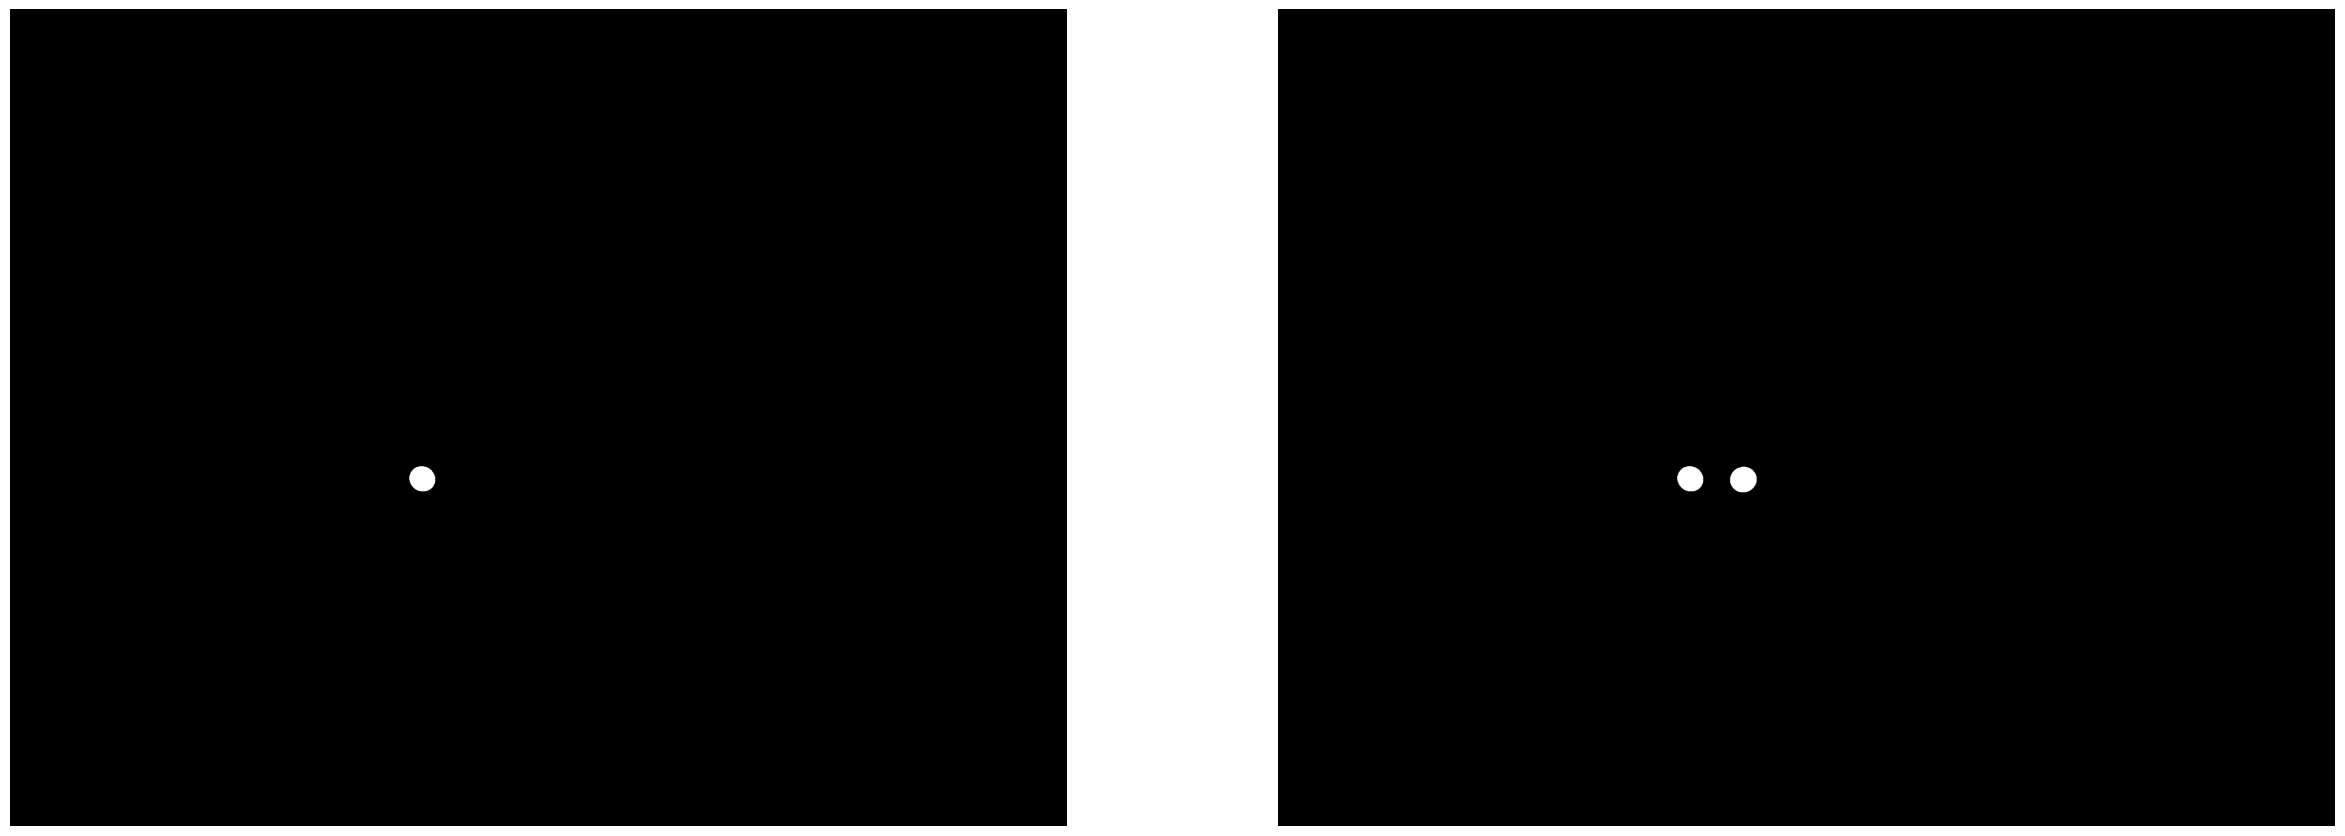

In [15]:
from scipy import ndimage

# Rote Pixel definieren (hier eher "kräftiges" Rot)
lower_red = np.array([100, 0, 0])   # min RGB
upper_red = np.array([255, 80, 80]) # max RGB

# Maske erstellen (True an roten Stellen)
mask1 = cv2.inRange(img1, lower_red, upper_red)
mask2 = cv2.inRange(img2, lower_red, upper_red)

# Pixel-Koordinaten der roten Punkte holen
coords = np.column_stack(np.where(mask1 > 0))
com1, com2 = ndimage.center_of_mass(mask1), ndimage.center_of_mass(mask2)
print(f"{len(coords)} rote Pixel gefunden")
py, px = mask1.shape
print("höhe: ", py, " breite: ", px)
test = np.zeros((int(py),int(px)))

y, x = map(int, com1)
test[y:y+10, x:x+10] = 1
combined_masks = np.logical_or(mask1, mask2)
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes[0].imshow(mask1, cmap='gray')
axes[0].axis('off')
axes[1].imshow(combined_masks, cmap='gray')
axes[1].axis('off')
print(ndimage.center_of_mass(mask1))
print(ndimage.center_of_mass(mask2))

(-0.5, 352.5, 272.5, -0.5)

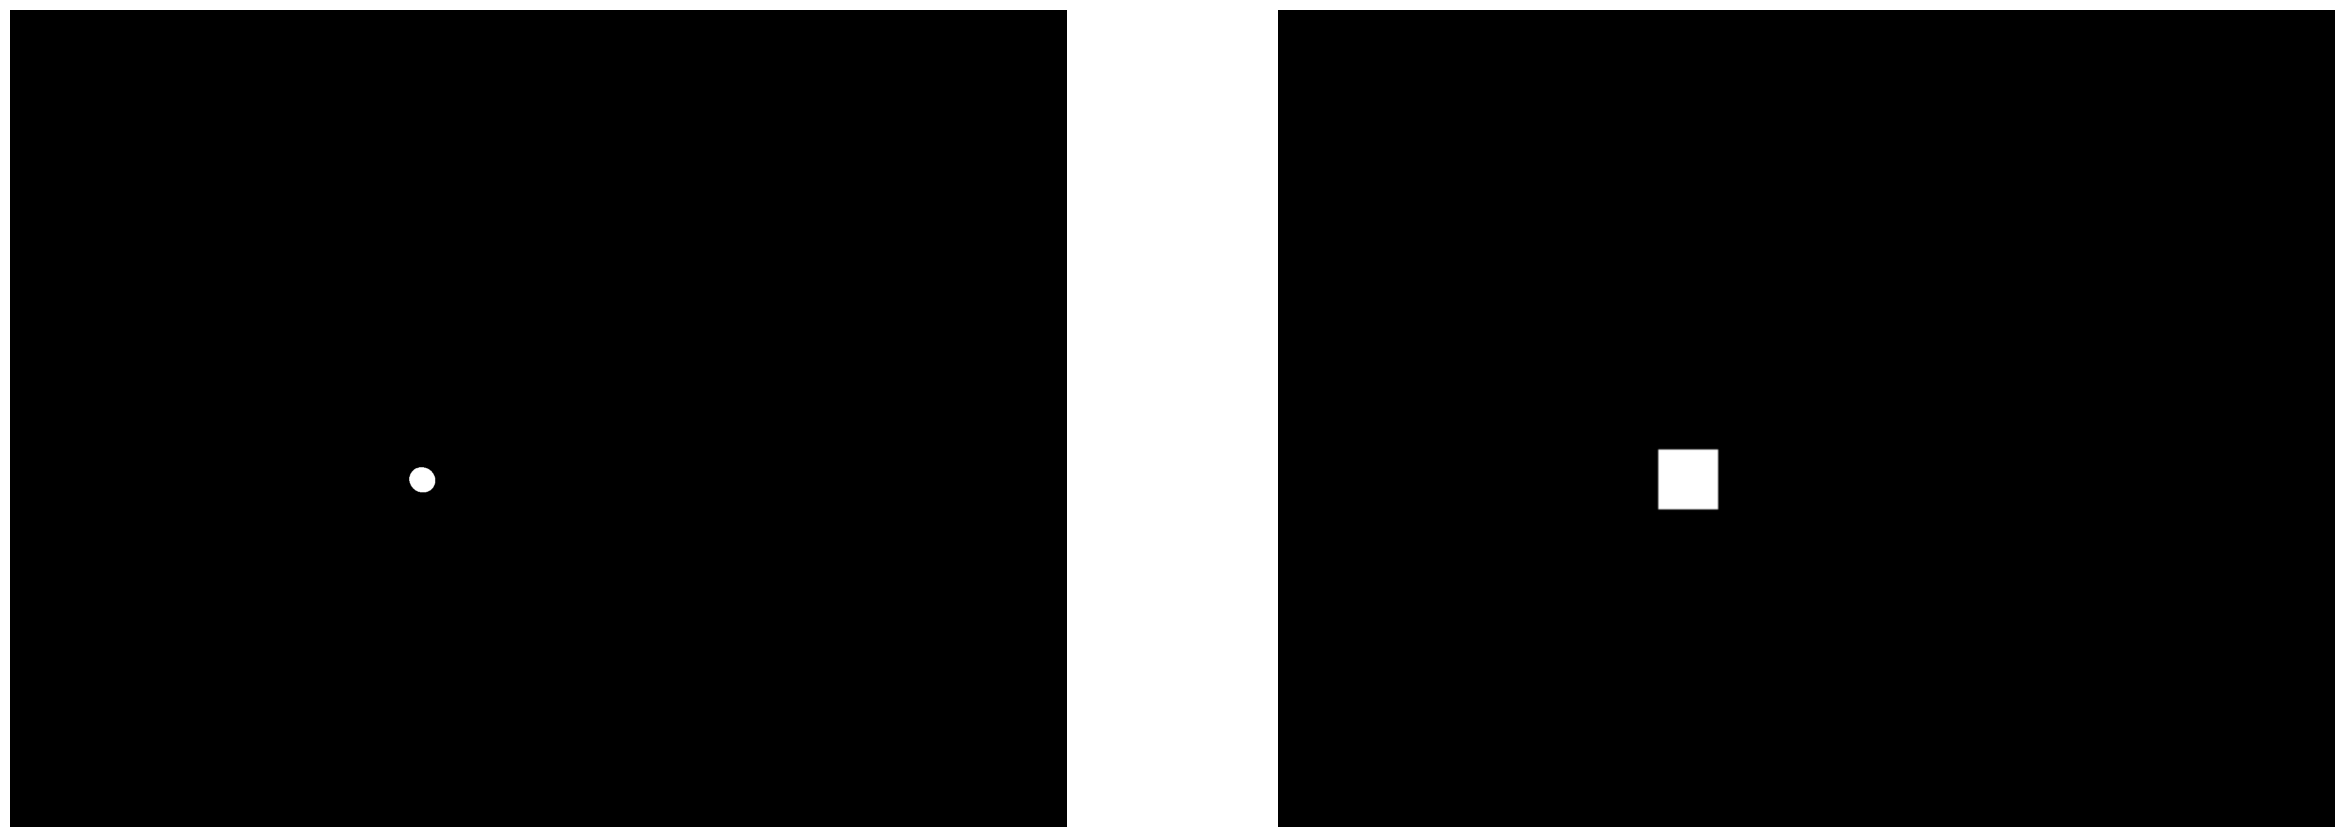

In [16]:
h=273
b = h * 11 / 8.5
s = 273.17/py
y, x = com1[0]*s, com1[1]*s
tescht = np.zeros((h, int(b)))
tescht[int(y-10):int(y+10), int(x-10):int(x+10) ] = 1

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
axes[0].imshow(mask1, cmap='gray')
axes[0].axis('off')
axes[1].imshow(tescht, cmap='gray')
axes[1].axis('off')


In [21]:
def getR(vc):
    up = np.array([0, 0, 1], dtype=float)
    origin = np.array([0, 0, 25], dtype=float)

    # Kamera schaut zum Ursprung
    zc = (origin - vc) / np.linalg.norm(origin - vc)

    # Rechte-Hand-System aufspannen
    xc = np.cross(up, zc)
    xc /= np.linalg.norm(xc)

    yc = np.cross(zc, xc)

    # Spalten = Achsen im Welt-KS
    R = np.column_stack((xc, yc, zc))
    return R


In [22]:
import numpy as np

def check_rotation_matrix(R, tol=1e-6):
    # Orthogonalitätsprüfung
    should_be_identity = R @ R.T
    I = np.eye(3)
    orthogonal = np.allclose(should_be_identity, I, atol=tol)

    # Determinantenprüfung
    det_R = np.linalg.det(R)
    proper = np.isclose(det_R, 1.0, atol=tol)

    return orthogonal and proper, orthogonal, proper, det_R


# Beispiel: dein R von getR(vc)
vc = np.array([25.0, 23.59, 200.0])
R = getR(vc)

ok, ortho, proper, detR = check_rotation_matrix(R)
print("R:\n", R)
print("Orthogonal:", ortho)
print("Determinante:", detR)
print("Gültige Rotationsmatrix:", ok)


R:
 [[ 0.68629884 -0.71368328 -0.14017874]
 [-0.72731967 -0.67343154 -0.13227266]
 [ 0.          0.19273333 -0.98125117]]
Orthogonal: True
Determinante: 1.0000000000000002
Gültige Rotationsmatrix: True


In [23]:
import numpy as np
print(com1)
def compute_K(image, fov_x_deg=39.6):
    """
    Berechnet die intrinsische Kameramatrix K aus einem Bild und horizontalem FoV.

    Args:
        image : np.ndarray
            Eingabebild (z. B. mit cv2.imread() geladen).
        fov_x_deg : float
            Horizontaler Öffnungswinkel (in Grad), Standardwert = 26.99° für 50mm.

    Returns:
        K : (3,3) np.ndarray
            Intrinsische Kameramatrix.
    """
    # Bildgröße auslesen (Achtung: .shape = (Höhe, Breite, Kanäle))
    h, w = image.shape[:2]

    # Winkel in Radiant
    fov_x = np.deg2rad(fov_x_deg)

    # Vertikaler Öffnungswinkel aus Aspect Ratio
    aspect = h / w
    print(aspect**-1, 11/8.5)
    fov_y = 2 * np.arctan(aspect * np.tan(fov_x / 2.0))

    # Brennweiten in Pixel
    fx = w / (2.0 * np.tan(fov_x / 2.0))
    fy = h / (2.0 * np.tan(fov_y / 2.0))

    # Hauptpunkt (Bildmitte)
    cx = w / 2.0
    cy = h / 2.0

    K = np.array([
        [fx, 0,  cx],
        [0,  fy, cy],
        [0,  0,   1]
    ], dtype=float)

    return K

# com1 = (u, v) Pixelkoordinate (Achtung: u = x = Spalte, v = y = Zeile)
v, u = com1

K = compute_K(img1, fov_x_deg=26.99)

# 1) Kamerarichtung: d_cam ∝ K^{-1}[u,v,1]
d_cam = np.linalg.inv(K) @ np.array([u, v, 1.0])
d_cam = d_cam / np.linalg.norm(d_cam)

# 2) In Weltkoordinaten: R_wc @ d_cam  (wenn getR(vc1) Spalten = x_c,y_c,z_c in Welt)
R_wc = getR(vc1)
d_world = R_wc @ d_cam
d_world = d_world / np.linalg.norm(d_world)

print("Strahl-Richtung (world):", d_world)

(1011.6323038397329, 887.7232888146912)
1.29375 1.2941176470588236
Strahl-Richtung (world): [-0.19401218 -0.29106883 -0.93682347]


In [1]:
# This cell computes rays for img1/img2 and plots:
# (a) the "original" camera rays that point from each camera center toward the world origin, and
# (b) the rays derived from the detected laser centroids in both images.
#
# It assumes you already have:
# - img1, img2: numpy arrays (images)
# - com1, com2: (u, v) centroid pixel coordinates for the laser blobs in each image
# - vc1, vc2: camera centers (3D) in world coordinates, shape (3,)
# - getR(vc): function returning R_wc with columns = camera axes (x_c, y_c, z_c) in world coordinates
# - compute_K(img, fov_x_deg): function returning K
#
# If any of these are missing, please define them before running.
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def pixel_to_world_ray(u, v, image, fov_x_deg, R_wc):
    """Return a unit direction vector in world coords from pixel (u,v)."""
    K = compute_K(image, fov_x_deg=fov_x_deg)
    d_cam = np.linalg.inv(K) @ np.array([float(u), float(v), 1.0])
    d_cam = d_cam / np.linalg.norm(d_cam)
    d_world = R_wc @ d_cam
    d_world = d_world / np.linalg.norm(d_world)
    return d_world


def unit(v):
    v = np.asarray(v, dtype=float)
    n = np.linalg.norm(v)
    if n == 0:
        return v
    return v / n


# Compute rotations for both cameras
R1 = getR(np.asarray(vc1, dtype=float))
R2 = getR(np.asarray(vc2, dtype=float))

# Compute world-direction rays from detected pixels
v1, u1 = com1
v2, u2 = com2

d1_world = pixel_to_world_ray(u1, v1, img1, 26.99, R1)
d2_world = pixel_to_world_ray(u2, v2, img2, 26.99, R2)


# "Original" camera rays pointing from camera centers toward origin (0,0,0)
origin = np.array([0, 25, 0])
r1_to_origin = unit(origin - np.asarray(vc1, dtype=float))
r2_to_origin = unit(origin - np.asarray(vc2, dtype=float))

# Plot setup
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Choose a common length for visualization
L = 300.0

# Plot camera centers
ax.scatter([vc1[0]], [vc1[1]], [vc1[2]], s=40, label="VC1")
ax.scatter([vc2[0]], [vc2[1]], [vc2[2]], s=40, label="VC2")
ax.scatter([0], [0], [25], s=40, label="World Origin")
ax.scatter([-10], [25], [25], s=40, label="Laser Punkt")

# Plot original rays (to origin)
t = np.linspace(0.0, 1.0, 2)
P1 = np.asarray(vc1) + np.outer(t * L, r1_to_origin)
P2 = np.asarray(vc2) + np.outer(t * L, r2_to_origin)
ax.plot(P1[:,0], P1[:,1], P1[:,2], label="VC1 → origin", linestyle="dotted", alpha=0.5)
ax.plot(P2[:,0], P2[:,1], P2[:,2], label="VC2 → origin", linestyle = "dotted", alpha=0.5)

# Plot measured pixel rays
Q1 = np.asarray(vc1) + np.outer(t * L, d1_world)
Q2 = np.asarray(vc2) + np.outer(t * L, d2_world)
ax.plot(Q1[:,0], Q1[:,1], Q1[:,2], label="VC1 pixel-ray")
ax.plot(Q2[:,0], Q2[:,1], Q2[:,2], label="VC2 pixel-ray")
print(P2[:,0], P2[:,1], P2[:,2])

# Axes labels and legend
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend(loc="best")
#würfel
# Ursprungswürfel-Koordinaten
x = [-25, 25]
y = [0, 50]
z = [-25, 25]

# Alle Eckpunkte generieren
cube_points = np.array([[xi, yi, zi] for xi in x for yi in y for zi in z])

# Linienpaare für die Würfelkanten
edges = [
    (0,1), (0,2), (0,4),
    (3,1), (3,2), (3,7),
    (5,1), (5,4), (5,7),
    (6,2), (6,4), (6,7),
    (3,6)
]

# Würfel plotten
for i,j in edges:
    ax.plot(
        [cube_points[i,0], cube_points[j,0]],
        [cube_points[i,1], cube_points[j,1]],
        [cube_points[i,2], cube_points[j,2]],
        color="gray"
    )

# Make the aspect look roughly equal
all_points = np.vstack([P1, P2, Q1, Q2, np.asarray(vc1)[None,:], np.asarray(vc2)[None,:], origin[None,:]])
mins = all_points.min(axis=0)
maxs = all_points.max(axis=0)
cent = (mins + maxs) / 2.0
extent = (maxs - mins).max() / 2.0 + 1e-6
ax.set_xlim(cent[0] - extent, cent[0] + extent)
ax.set_ylim(cent[1] - extent, cent[1] + extent)
ax.set_zlim(cent[2] - extent, cent[2] + extent)
ax.view_init(elev=90, azim=-90)

plt.show()


NameError: name 'getR' is not defined